Implementation of the longest-queue policy introduced in the paper 'On the Optimality of Greedy Policies in Dynamic Matching' by Suleyman Kerimov, Itai Ashlagi, and Itai Gurvich.

In [1]:
import sys
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
def draw_hypergraph(lambda_, M, r):
    """
    Given the arrivals, match types, and rewards, draws the corresponding hypergraph
    
    Inputs:
        lambdas - arrival rates, list
        M - a matrix representing the participants of the matches (horizontal), matrix
        r - rewards, list
        
    Output: None
    """
    M = M.T

    vertices = [str(j+1)+" : "+str(i)+"λ" for j, i in enumerate(lambda_)]
    
    edges = []
    for row in M.T:
        new = []
        for i in range(len(row)):
            if row[i] == 1:
                new.append(vertices[i])
        edges.append(new)


    plt.figure(figsize=(8, 4))
    # Define the hypergraph
    hypergraph = {
        'vertices': vertices,
        'edges': edges
    }

    # Create a NetworkX graph object
    graph = nx.Graph()

    # Add the vertices to the graph
    graph.add_nodes_from(hypergraph['vertices'], bipartite=0)

    # Add the hyperedges to the graph
    for i, edge in enumerate(hypergraph['edges']):
        hyperedge_id = f'r{i+1} = '+str(r[i])  # Unique identifier for each hyperedge
        graph.add_node(hyperedge_id, bipartite=1)  # Add hyperedge as a node
        graph.add_edges_from([(v, hyperedge_id) for v in edge])  # Connect vertices to the hyperedge

    # Set the bipartite layout
    pos = nx.bipartite_layout(graph, hypergraph['vertices'], align='horizontal')

    # Separate the nodes based on bipartite attribute
    vertices = [node for node in graph.nodes if graph.nodes[node]['bipartite'] == 0]
    hyperedges = [node for node in graph.nodes if graph.nodes[node]['bipartite'] == 1]


    # Draw the nodes with different shapes
    nx.draw_networkx_nodes(graph, pos, nodelist=vertices, node_color='lightblue', node_shape='o', node_size=4000)
    nx.draw_networkx_nodes(graph, pos, nodelist=hyperedges, node_color='lightblue', node_shape='s', node_size=4000)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), width=2, alpha=0.5, edge_color='gray')

    # Draw the labels
    nx.draw_networkx_labels(graph, pos, font_size=9)
    
    M = M.T

    # Display the graph
    plt.axis('off')
    plt.show()

In [3]:
def arrival(lambdas):
    """
    Given the arrival rates, this function randomly generates a single arrival 
    
    Inputs:
        lambdas - arrival rates, list
    
    Output: a list of 0s and 1 representing the single arrival, list
    """
    events = list(range(0, len(lambdas)))
    res = [0] * len(lambdas)
    res[random.choices(events, lambdas)[0]] = 1
    return np.array(res)

In [4]:
def hindsight_solution(lambdas, M, r, A, t):
    """
    Perfoms the hindsight optimization for arrivals that happened before t.
    
    Inputs:
        lambdas - arrival rates, list
        M - a matrix representing the participants of the matches (horizontal), matrix
        r - rewards, list
        A - a matrix representing true arrivals, matrix
        t - time point, int
    
    Output: objective value, int
    """

    m = gp.Model("Hindight Solution")
    m.setParam("Outputflag", 0)

    z = m.addMVar(len(r), lb=0, vtype=gp.GRB.INTEGER, name = "z var")
    m.setObjective(r @ z, GRB.MAXIMIZE)
    m.addConstr(M.T @ z <= sum(A[:t+1]))
    m.optimize()

    return m.objVal

In [18]:
def preprocessing(lambdas, M, r):
    """
    Normalizes the arrival rates.
    Check if the input sizes match.
    Solves the static-planning problem to find the general position gap.
    Checks if the problem satisfies the general position condition
    
    Inputs:
        lambdas - arrival rates, list;
        M - a matrix representing the participants of the matches (horizontal), matrix;
        r - rewards, list.
    
    Output: updated lambdas, M, r, epsilon.
    """
    print("\n\n-----------------")
    
    # Normalize lambdas
    lambdas = np.array(lambdas)
    lambdas = (lambdas/lambdas.sum())
    
    
    # Check if the input sizes match
    for i in M:
        if len(i) != len(lambdas):
            print("sizes of M and lambdas don't match")
            return False
        
    if len(r) != len(M):
        print("sizes of M and r don't match")
        return False
    
    # Statis Planning Problem
    m = gp.Model("SPP")
    m.setParam("Outputflag", 0)

    z = m.addMVar(len(r), lb=0, vtype=gp.GRB.CONTINUOUS, name = "z var")
    s = m.addMVar(len(lambdas), lb=0, vtype=gp.GRB.CONTINUOUS, name = "slack var")
    m.setObjective(r @ z, GRB.MAXIMIZE)
    m.addConstr(M.T @ z + s == lambdas)
    m.optimize()
    
    
    # Find GPG and check GPC
    num = 0  # |Q+| + |M+|, used to check GPC
    epsilon = float("inf")
    for i in s.X:
        if i > 0:
            num += 1
            if i < epsilon:
                epsilon = i
    Q_demand = s.X.copy()
    
    for i in z.X:
        if i > 0:
            num += 1
            if i < epsilon:
                epsilon = i
    
    if num != len(lambdas):
        print("Warning: General Position Condition does not hold!")
    else:
        print("Satisfies the General Position Condition ✓")
        
    # Remove redundant
    redundant = [i for i in range(len(r)) if z.X[i] == 0]
    count = 0
    for idx in redundant:
        M = np.delete(M, idx -  count, axis = 0)
        r = np.delete(r, idx - count)
        count += 1
    print("Removed matches: ", redundant)
        
    return lambdas, M, r, epsilon, Q_demand

In [19]:
def longest_queue(lambdas, M, r, T = 500):
    """
    Perfoms the longest queue algorithm.
    Calculates and plots the regret and # of waiting agents over time.
    
    Inputs:
        lambdas - arrival rates, list
        M - a matrix representing the participants of the matches (horizontal), matrix
        r - rewards, list
        T - number of decision epochs, int
    
    Output: A, X, queue_hist, regret
    """
    lambdas, M, r, epsilon, Q_demand = preprocessing(lambdas, M, r)
    
    print("Epsilon: ", epsilon)
    
    A = [np.zeros(len(lambdas))]     # arrival history
    X = [np.zeros(len(r))]           # realized matches history
    queue_hist = [np.zeros(len(lambdas))] # queue history
    regret = [0]
    reward = [0]
    hindsight = [0]
    
    for t in range(1, T):
        # Observe arrival
        arriv = arrival(lambdas)
        A.append(arriv)
        
        queue = arriv + queue_hist[-1]
        
        maxIdx = 0
        currentMax = 0
        exists = False
        
        for idx in range(len(r)):
            if (arriv <= M[idx]).all() and (queue >= M[idx]).all():
                if M[idx] @ queue > currentMax:
                    currentMax = M[idx] @ queue
                    maxIdx = idx
                    exists = True
                elif M[idx] @ queue == currentMax:
                    if random.uniform(0, 1) > 0.5:
                        maxIdx = idx
                        exists = True
                        
        x = np.zeros(len(r))
        if exists:
            x[maxIdx] = 1
        X.append(x)
        
        queue = queue - M.T @ x
        
        # At the end of each time period (after a match is performed), 
        # all agents of types i ∈ Q+ leave the market unmatched.                  
        if not exists:
            INDEX = 0
            for ma in range(len(arriv)):
                if arriv[ma] == 1:
                    INDEX = ma
                    break
            if Q_demand[INDEX] > 0.00001:
                queue[INDEX] -= 1
        
        queue_hist.append(queue)
        
        reward.append(reward[-1] + r @ x)
        hindsight.append(hindsight_solution(lambdas, M, r, A, t))
        regret.append(hindsight[-1] - reward[-1])
    
    plt.plot(range(0, T), regret, label = "regret")
    plt.xlabel('time')
    plt.ylabel('regret')
    plt.title('regret vs time')
    plt.show()
    
    plt.plot(range(0, T), hindsight, label = "hindsight")
    plt.plot(range(0, T), reward, label = "longest-queue")
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('reward')
    plt.title('hinsight & longest-queue vs time')
    plt.show()
    
    return A, X, queue_hist, regret, reward, hindsight
    

## Experiment 1 (trivial network)

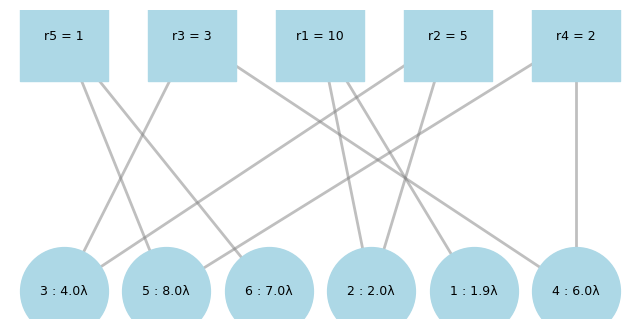

In [25]:
# figure 5, p. 32
r = np.array([10, 5, 3, 2, 1])
M = np.array([[1, 1, 0, 0, 0, 0],
              [0, 1, 1, 0, 0, 0],
              [0, 0, 1, 1, 0, 0],
              [0, 0, 0, 1, 1, 0],
              [0, 0, 0, 0, 1, 1]])
lambdas = np.array([1.9, 2, 4, 6, 8, 7])

draw_hypergraph(lambdas, M, r)



-----------------
Satisfies the General Position Condition ✓
Removed matches:  []
Epsilon:  0.003460207612456759


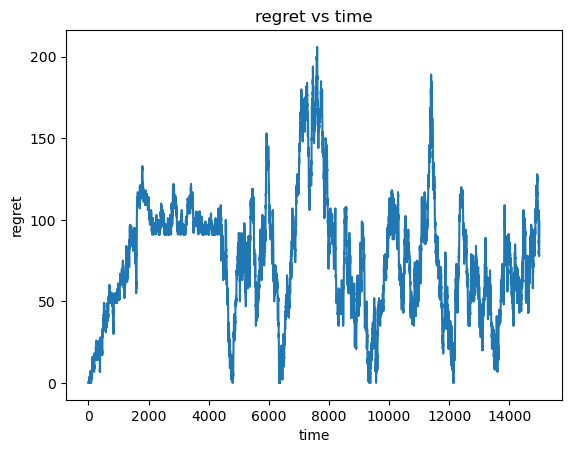

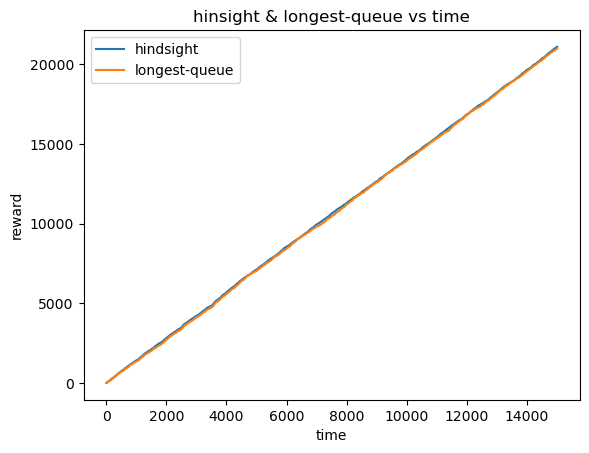

In [26]:
A, X, queue_hist, regret, reward, hindsight = longest_queue(lambdas, M, r, T = 15000)

## Experiment 2 (trivial, figure 5, p. 32 - second paper)

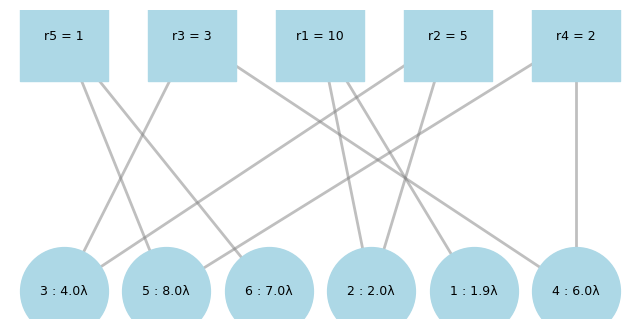



-----------------
Satisfies the General Position Condition ✓
Removed matches:  []
Epsilon:  0.003460207612456759


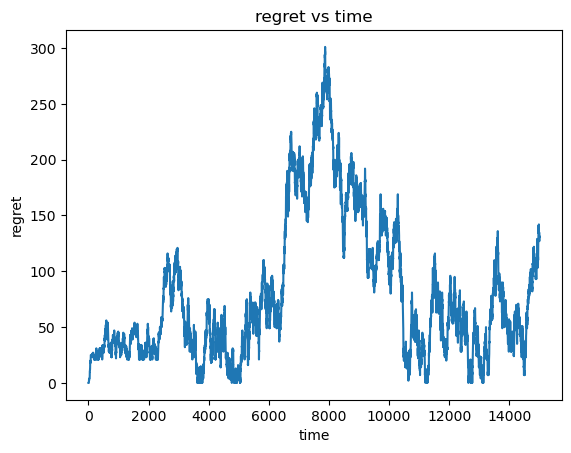

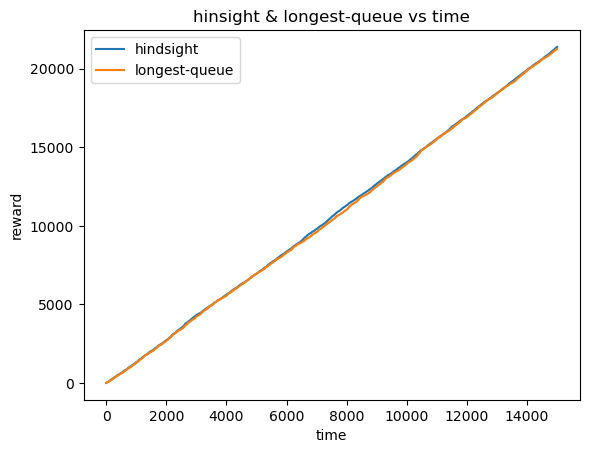

In [27]:
r = np.array([10, 5, 3, 2, 1])
M = np.array([[1, 1, 0, 0, 0, 0],
              [0, 1, 1, 0, 0, 0],
              [0, 0, 1, 1, 0, 0],
              [0, 0, 0, 1, 1, 0],
              [0, 0, 0, 0, 1, 1]])
lambdas = np.array([1.9, 2, 4, 6, 8, 7])

draw_hypergraph(lambdas, M, r)

A, X, queue_hist, regret, reward, hindsight = longest_queue(lambdas, M, r, T = 15000)

## Experiment 3 (multi-way)

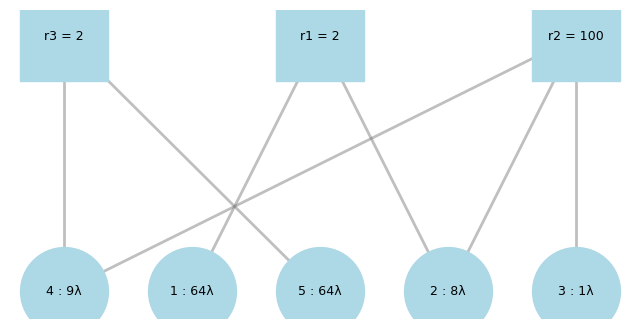

In [28]:
r = np.array([2, 100, 2])
M = np.array([[1, 1, 0, 0, 0],
              [0, 1, 1, 1, 0],
              [0, 0, 0, 1, 1]])
lambdas = np.array([64, 8, 1, 9, 64])

draw_hypergraph(lambdas, M, r)



-----------------
Satisfies the General Position Condition ✓
Removed matches:  []
Epsilon:  0.00684931506849315


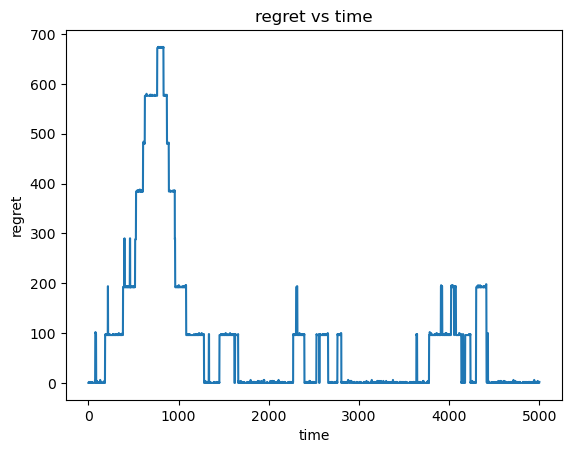

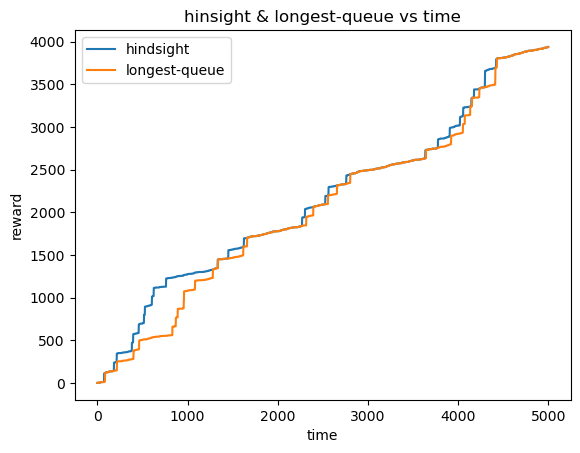

In [29]:
A, X, queue_hist, regret, reward, hindsight = longest_queue(lambdas, M, r, T = 5000)